<a href="https://colab.research.google.com/github/RyanSolving/PainPoints_Extracter/blob/main/WoolWorthsReviews_Preprocessing_RuleMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install fuzzywuzzy -qU
!pip install spacy pandas textblob nltk -qU
!python -m spacy download en_core_web_sm -qU

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import sqlite3
import re
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
nltk.download('stopwords')    # For stop words (e.g., "the", "a")
nltk.download('punkt')        # For tokenization (splitting text into words)
nltk.download('averaged_perceptron_tagger')  # For part-of-speech (POS) tagging
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')      # For lemmatization (optional, but recommended)
nltk.download('omw-1.4')      # Open Multilingual WordNet (optional)
nltk.download('punkt_tab')
nlp = spacy.load('en_core_web_sm')

In [ ]:
stop_words = stopwords.words('english')

# Load data

In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/Projects/Woolies Reviews/wwreviews.db')
df_reviews = pd.read_sql_query('Select * From reviews_list',conn)
df_stores = pd.read_sql_query('Select * From stores_list',conn)
reviews = df_reviews[df_reviews['ReviewTextFull'].str.len()>0][['StoreName','ReviewTextFull','Rating','TimeReview']]

# Text preprocessing

## Remove duplicated value

In [ ]:
reviews = reviews.drop_duplicates(subset='ReviewTextFull')

In [ ]:
def get_wordnet_pos(pos_tag):
  if pos_tag.startswith('J'):
    return wordnet.ADJ
  elif pos_tag.startswith('V'):
    return wordnet.VERB
  elif pos_tag.startswith('N'):
    return wordnet.NOUN
  elif pos_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN
lemmatizer = WordNetLemmatizer()
def text_preprocess(text):
  #Lowercase
  text = text.lower()
  #Extract only characters
  text = re.sub(r'[^a-zA-Z0-9\s.,!?;:]',' ',text)
  #Review extra whitespace
  text = re.sub(r'\s+',' ',text).strip()
  #Lemmatizer
  words = word_tokenize(text)
  pos_tags = pos_tag(words)
  lemmatized_words = []
  for word, tag in pos_tags:  # Fixed variable name conflict (pos_tag -> tag)
      wn_pos = get_wordnet_pos(tag)
      lemma = lemmatizer.lemmatize(word, wn_pos)
      lemmatized_words.append(lemma)
  text = ' '.join(lemmatized_words)
  #clean white space
  text = re.sub(r'\s+([.,!?;:])', r'\1', text)

  return text


In [ ]:
reviews['ProcessedReview'] = reviews['ReviewTextFull'].apply(text_preprocess)
#Exclude reviews with its length less than 10 words
reviews = reviews[reviews['ProcessedReview'].str.len()>10]

## Engineering "year" column

In [ ]:
def year_calculation(text):
  less_than_a_year = ['month','week','day','hour']
  if any(date_unit in text for date_unit in less_than_a_year):
    return 2024
  else:
    return 2024 - int(text.split(" ")[0]) if text.split(" ")[0] != 'a' else 2024 -1
reviews['Year'] = reviews['TimeReview'].apply(year_calculation)

# Aspects extraction

In [ ]:
plt.figure(figsize=(5,3))
(reviews
 ['Rating']
 .value_counts()).plot(kind='bar')
plt.title('Customer Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Comment** There's good sign since majority of positive feedback (>3).

## Framework to analyze painpoints

In [ ]:
def noun_adj_extracter(text):
    doc = nlp(text)
    nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and len(token.text) > 2]
    adjectives = [token.text.lower() for token in doc if token.pos_ == 'ADJ']
    return pd.Series([nouns, adjectives])

In [ ]:
reviews[['noun','adj']] = reviews['ProcessedReview'].apply(noun_adj_extracter)

In [ ]:
noun_frequency = (reviews['noun']
                    .explode()
                    .value_counts(normalize=True)
                    .reset_index()
                    .assign(cumsum = lambda x: np.cumsum(x['proportion'])))

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def sentiment_analysis(aspect,text):
  sent_token = sent_tokenize(text)
  sent_aspect = [sent for sent in sent_token if aspect in sent]
  if not sent_aspect:
      return 0

  result = [sia.polarity_scores(sent)['compound'] for sent in sent_aspect]

  return np.mean(result)


To define customer painpoint, it would be: [Noun] and its sentiment

In [ ]:
noun_aspect_analysis =(reviews
                        [['Rating', 'Year', 'ProcessedReview','noun']]
                        .explode('noun')
                        .dropna(subset=['noun'])
                        .assign(sentiment=lambda x: x.apply(lambda row: sentiment_analysis(row['noun'], row['ProcessedReview']), axis=1))
                        )
noun_sentiment = noun_aspect_analysis.pivot_table(
                      index=['Rating', 'Year', 'ProcessedReview'],
                      columns='noun',
                      values='sentiment',
                      aggfunc='first',
                      fill_value=0
                  ).reset_index()

In [ ]:
adj_aspect_analysis =(reviews
                        [['Rating', 'Year', 'ProcessedReview','adj']]
                        .explode('adj')
                        .dropna(subset=['adj'])
                        .assign(sentiment=lambda x: x.apply(lambda row: sentiment_analysis(row['adj'], row['ProcessedReview']), axis=1))
                        )
adj_sentiment = adj_aspect_analysis.pivot_table(
                      index=['Rating', 'Year', 'ProcessedReview'],
                      columns='adj',
                      values='sentiment',
                      aggfunc='first',
                      fill_value=0
                  ).reset_index()

Question 1: What are the aspect frequency?

In [ ]:
adj_sentiment = adj_aspect_analysis.pivot_table(
                      index=['Rating', 'Year', 'ProcessedReview'],
                      columns='adj',
                      values='sentiment',
                      aggfunc='first',
                      fill_value=0
                  ).reset_index()

In [ ]:
#Zip sentiment versus frequency keyword of noun
top_10_keywords = (reviews
 [reviews['Rating']<3]
 ['noun']
 .explode()
 .value_counts()).head(10).index.tolist()

noun_sentiment[noun_sentiment['Rating']<3][top_10_keywords].describe()


noun,staff,store,customer,service,time,item,woolworth,checkout,self,people
count,6230.000000,6230.000000,6230.000000,6230.000000,6230.000000,6230.000000,6230.000000,6230.000000,6230.000000,6230.000000
mean,-0.036994,-0.018420,-0.031784,-0.041422,-0.018145,-0.008935,-0.012071,-0.010167,-0.014494,-0.004818
std,0.262893,0.212382,0.219210,0.213703,0.174117,0.136204,0.155659,0.131104,0.141099,0.146133
min,-0.986500,-0.986500,-0.969800,-0.986500,-0.976100,-0.962200,-0.966200,-0.943300,-0.965900,-0.986500
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.963600,0.963600,0.927400,0.933400,0.949000,0.966600,0.963600,0.916800,0.883400,0.952000


In [ ]:
#Zip sentiment versus frequency keyword of noun
top_10_keywords = (reviews
 [reviews['Rating']>3]
 ['noun']
 .explode()
 .value_counts()).head(10).index.tolist()

noun_sentiment[noun_sentiment['Rating']>3][top_10_keywords].describe()


noun,staff,store,service,shop,supermarket,place,stock,woolworth,parking,product
count,22279.000000,22279.000000,22279.000000,22279.000000,22279.000000,22279.000000,22279.000000,22279.00000,22279.000000,22279.000000
mean,0.203222,0.102972,0.074893,0.044608,0.036870,0.047686,0.045045,0.03137,0.031428,0.036121
std,0.335995,0.251959,0.224899,0.173641,0.155572,0.177758,0.174237,0.14591,0.147562,0.158304
min,-0.916800,-0.906200,-0.891600,-0.820100,-0.817200,-0.904500,-0.916800,-0.92920,-0.909800,-0.830500
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.493900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,0.987800,0.989700,0.993300,0.996800,0.987800,0.996800,0.981100,0.97940,0.976100,0.986100


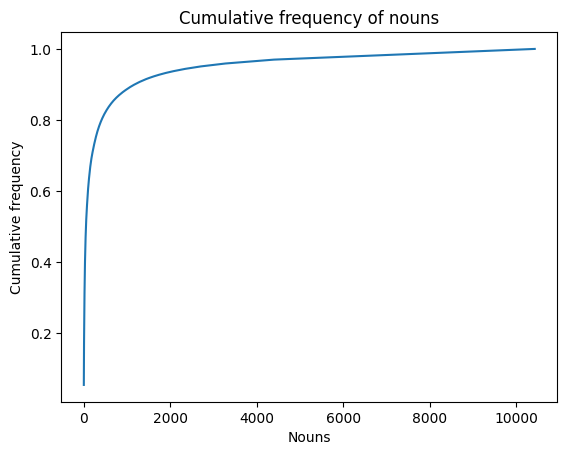

In [ ]:
noun_frequency['cumsum'].plot(kind='line')
plt.title('Cumulative frequency of nouns')
plt.xlabel('Nouns')
plt.ylabel('Cumulative frequency')
plt.show()

**Comment** There's small amount of noun that frequently mentioned by customers

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      max_words=100,
                      colormap='viridis',
                      contour_width=1,
                      contour_color='steelblue')

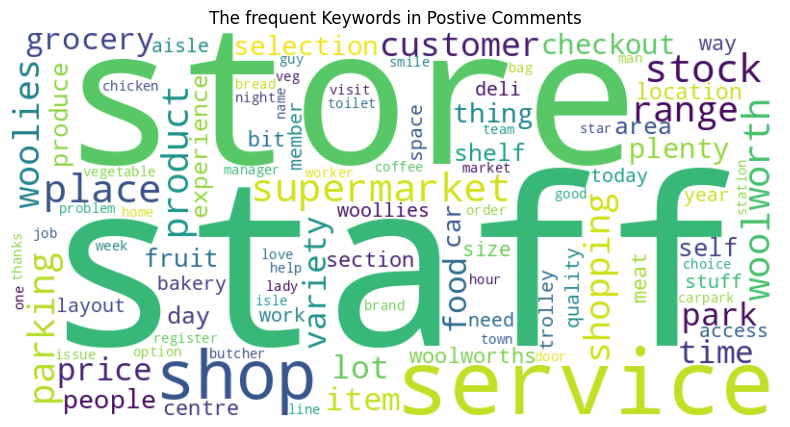

In [ ]:
#The most frequency word in positive comments
wordcloud.generate_from_frequencies(dict((reviews
 [reviews['Rating']>3]
 ['noun']
 .explode()
 .value_counts()
 .reset_index()
 .pipe(lambda x: list(zip(x['noun'],x['count'])))
 )))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('The frequent Keywords in Postive Comments')
plt.axis('off')
plt.show()

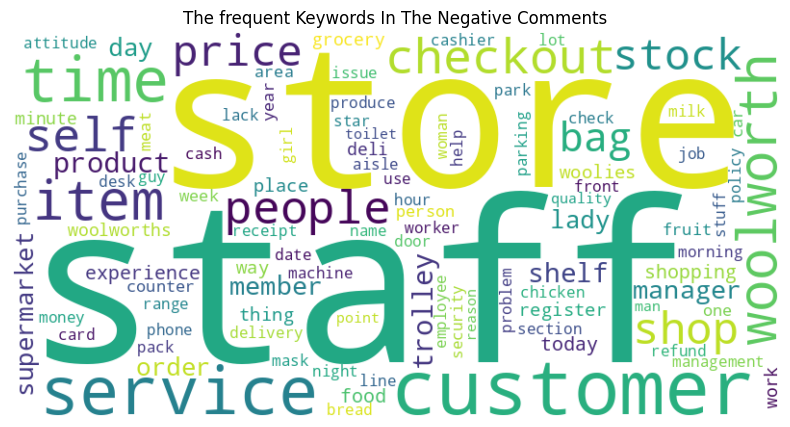

In [ ]:
#The most frequency word in negative comments
wordcloud.generate_from_frequencies(dict((reviews
 [reviews['Rating']<3]
 ['noun']
 .explode()
 .value_counts()
 .reset_index()
 .pipe(lambda x: list(zip(x['noun'],x['count'])))
 )))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('The frequent Keywords In The Negative Comments')
plt.axis('off')
plt.show()

In [ ]:
wordcloud.generate_from_frequencies(dict(zip(noun_frequency['noun'],noun_frequency['proportion'])))

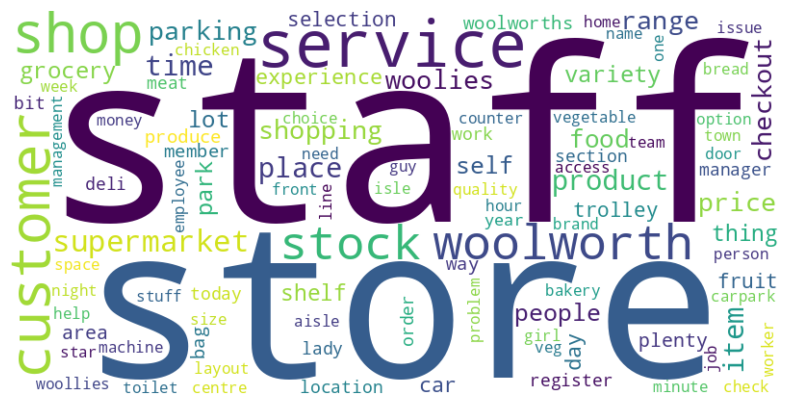

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Comment** WoolWorth's customers were talking about staff, store, service, stock, customer

Question: How about the adjective frequency?

In [ ]:
adj_frequency = (reviews['adj']
                    .explode()
                    .value_counts(normalize=True)
                    .reset_index()
                    .assign(cumsum = lambda x: np.cumsum(x['proportion'])))

In [ ]:
wordcloud.generate_from_frequencies(dict(zip(adj_frequency['adj'],adj_frequency['proportion'])))

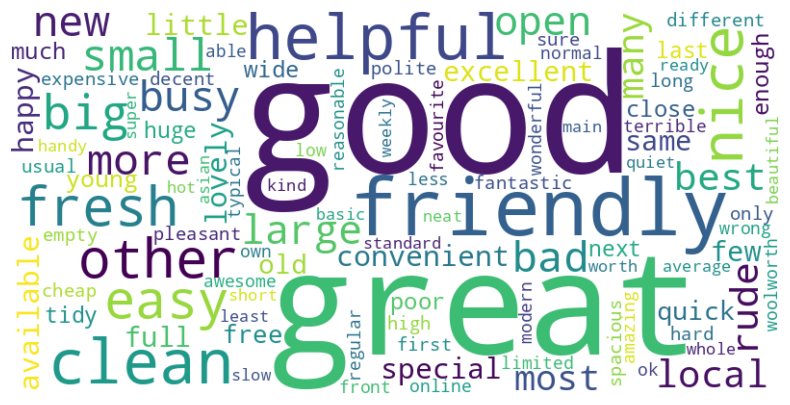

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**comment** Almost the customer feedbacks were suggested a postive mood of shoppers. "Good", "Great" and "Friendly" were mainly mentioned

In [ ]:
bad_reviews = (reviews
                .query('Rating<3')
                [['ProcessedReview','Year','noun','adj']])

Question: What did bad reviews talk about?

**comment** In negative reviews, the majority reviews mentioned about store, staff, customer, service. let's check out how about adjective.

In [ ]:
noun_frequency = (bad_reviews
                    ['noun']
                    .explode()
                    .value_counts(normalize=True)
                    .reset_index()
                    .pipe(lambda x: list(zip(x['noun'],x['proportion']))))
wordcloud.generate_from_frequencies(dict(noun_frequency))

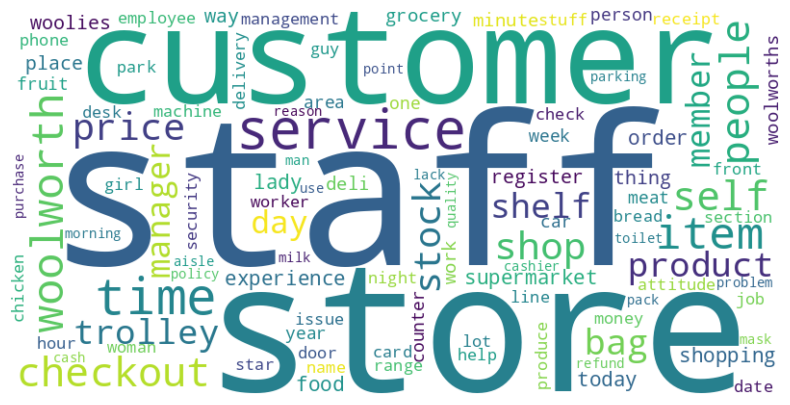

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
adj_frequency = (bad_reviews
                 ['adj']
                 .explode()
                 .pipe(lambda x: x.value_counts(normalize=True))
                 .reset_index()
                 .pipe(lambda x: list(zip(x['adj'],x['proportion']))))
wordcloud.generate_from_frequencies(dict(adj_frequency))

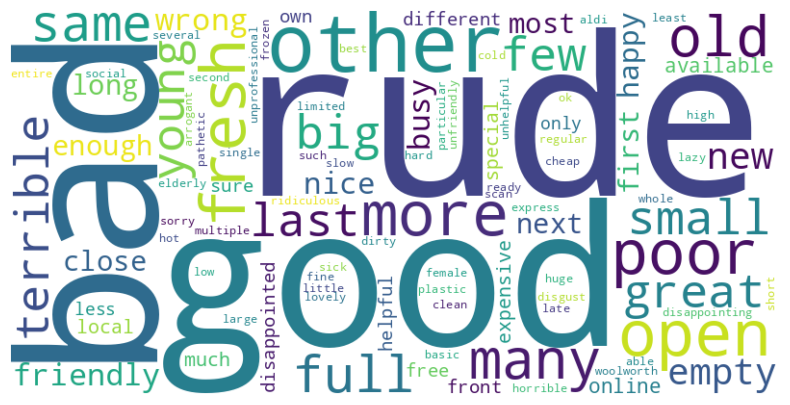

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**comment** spot on some positive and negative common adjective words in bad reviews, including: Good, Rude, Bad, Other, Open, Poor, Fresh

In [ ]:
pipeline = (bad_reviews
            [['Year','noun']]
            .explode('noun')
            .value_counts()
            .reset_index()
            .pivot_table(index='Year',
                          columns='noun',
                          values='count',
                          aggfunc='sum',
                          fill_value=0)
            .pipe(lambda x: {'keywords_by_year':x,
                              'diff_by_year':x.diff(axis=0).iloc[1:,:]}))
change_magnitude = (pipeline['diff_by_year']
                    .pipe(lambda x: pd.DataFrame({'Keywords':x.columns,
                                                  'Change_norm':np.linalg.norm(x,axis=0)})
                    .sort_values(by='Change_norm',ascending=False)
                    ))

Text(0, 0.5, 'L2 norm')

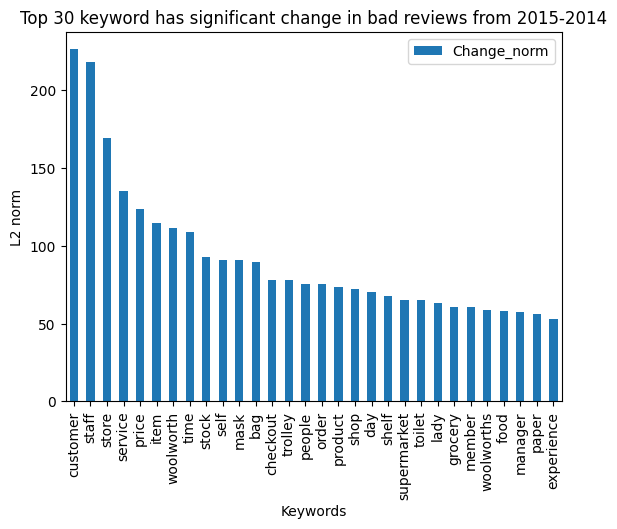

In [ ]:
change_magnitude.head(30).set_index('Keywords').plot(kind='bar')
plt.title('Top 30 keyword has significant change in bad reviews from 2015-2014')
plt.xlabel('Keywords')
plt.ylabel('L2 norm')

Let inspect its direction

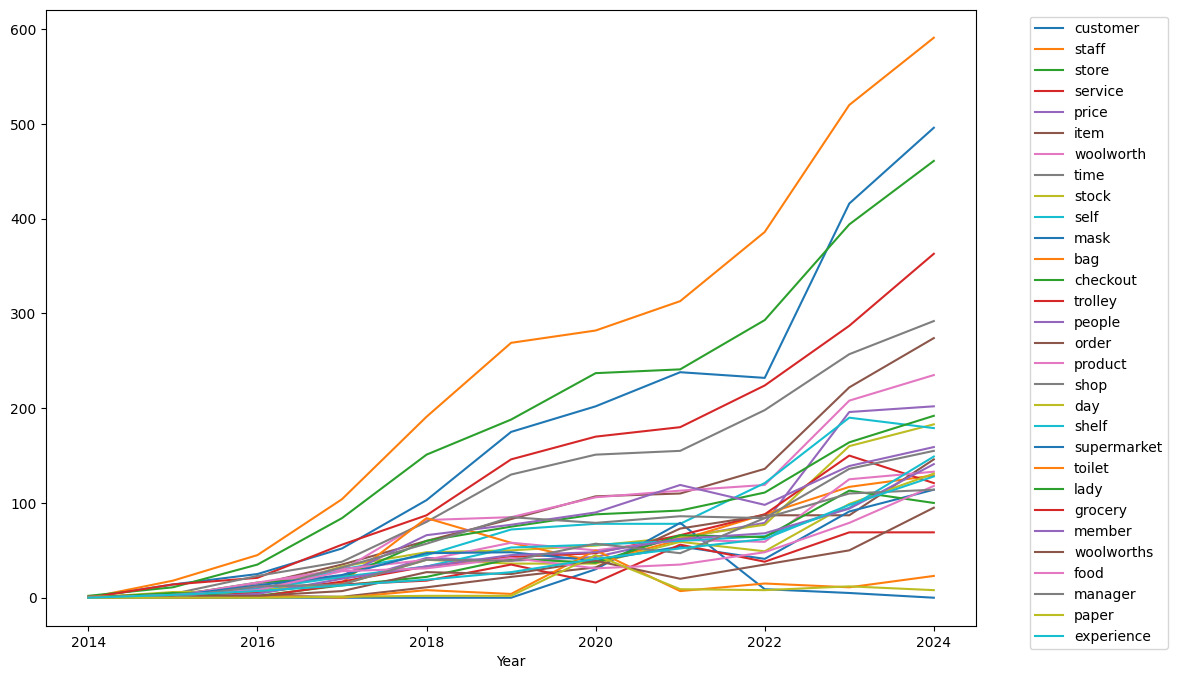

In [ ]:
(pipeline['keywords_by_year']
 [change_magnitude.head(30)['Keywords'].tolist()]).plot(kind='line', figsize=(12,8))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

**Comment** Staff, customer, store, service were mostly mentioned in bad reviews all the time. Probably, the supermarket seem like have problem with store's staff and customer service. Before conclusing, we need to inspect the change in adjective words

Text(0, 0.5, 'Change frequency')

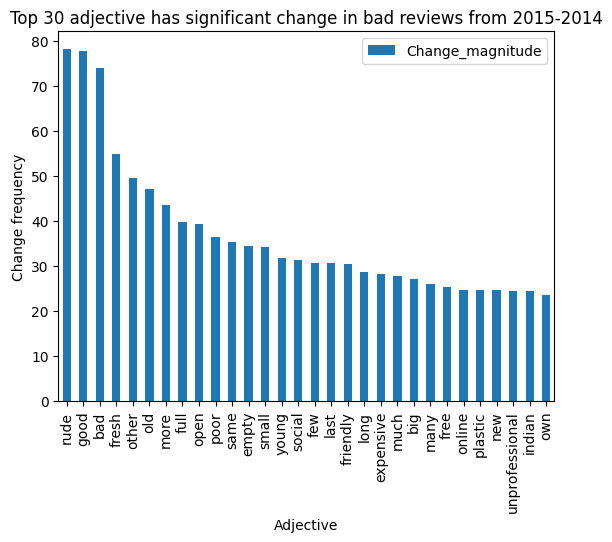

In [ ]:
pipeline = (bad_reviews
            [['Year','adj']]
            .explode('adj')
            .value_counts()
            .reset_index()
            .pivot_table(index='Year',
                          columns='adj',
                          values='count',
                          aggfunc='sum',
                          fill_value=0)
            .pipe(lambda x: {'change_by_year':x,
                              'diff_change_by_year':x.diff(axis=0)}))
#Top 30 word change significantly
change_magnitude = (pipeline['diff_change_by_year']
                    .iloc[1:,:]
                    .pipe(lambda x: pd.DataFrame({'Keywords':x.columns,
                                                  'Change_magnitude': np.linalg.norm(x,axis=0)}))
                    .sort_values(by='Change_magnitude',ascending=False)
                    .head(30)
                    .set_index('Keywords')
                    )
change_magnitude.plot(kind='bar')
plt.title('Top 30 adjective has significant change in bad reviews from 2015-2014')
plt.xlabel('Adjective')
plt.ylabel('Change frequency')

Let inspect for change direction

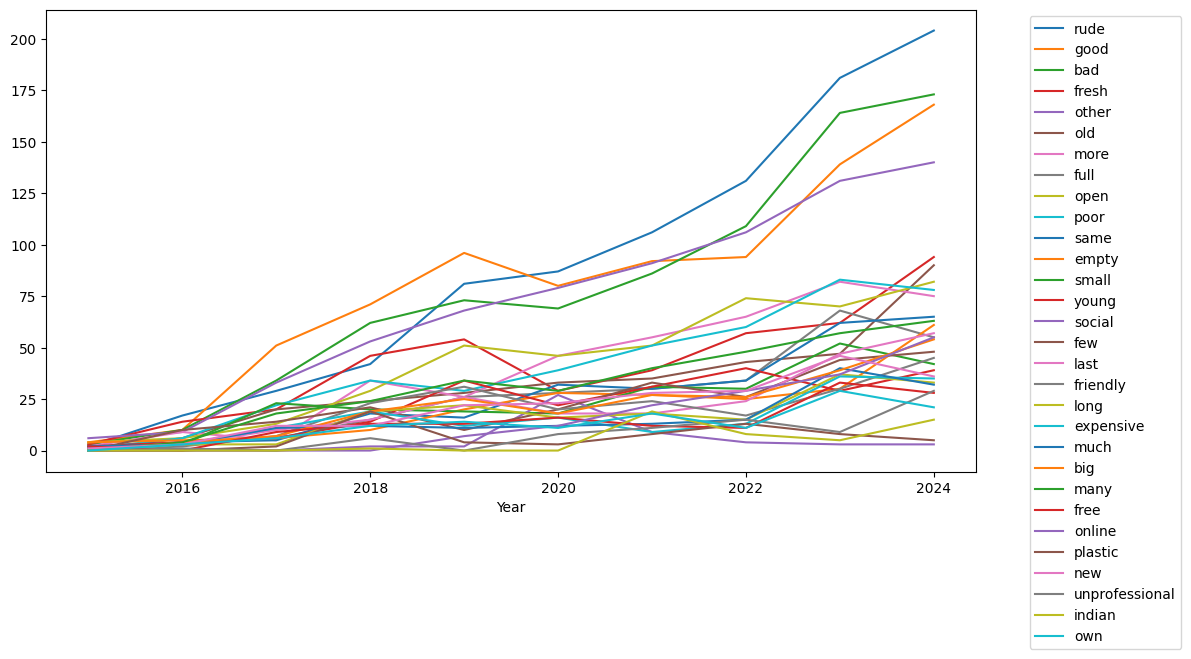

In [ ]:
(pipeline['change_by_year']
 .iloc[1:,:]
 [change_magnitude.index.tolist()]
 ).plot(kind='line',figsize=(12,6))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Rude, bad are the most common keywords in bad reviews from customer reviews. So, the potential problem of customer satisfaction were likely customer services and staff attitude.

In [ ]:
#Find the co-occurence of these noun and adj
#time-frame: 2 year 2023-2024
#top 30 frequently mention
top30_nouns = (bad_reviews
                [bad_reviews['Year']>=2023]
                ['noun']
                .explode()
                .value_counts()
                .sort_values(ascending=False)
                .head(30)
                )
top30_adj = (bad_reviews
                [bad_reviews['Year']>=2023]
                ['adj']
                .explode()
                .value_counts()
                .sort_values(ascending=False)
                .head(30)
                )
#possible joint
joint_noun_adj = (bad_reviews
                  [bad_reviews['Year']>2023]
                  .assign(pair = lambda x:
                          x.apply(
                              lambda row:
                               [(noun,adj) for noun in row['noun'] for adj in row['adj']],
                              axis=1)
                          )
                  .explode('pair')
                  ['pair']
                  .value_counts()
                  .reset_index(name='count')
                  .rename(columns={'index':'pair'})
                  )
#Reconstruct dataframe
top30_nounadj_df = pd.DataFrame(index=top30_nouns.index,
                                columns=top30_adj.index)

for noun in top30_nouns.index:
  for adj in top30_adj.index:
    # Handle potentially missing pairs with a try-except block
    try:
      count = joint_noun_adj[joint_noun_adj['pair']==(noun,adj)]['count'].values
      top30_nounadj_df.loc[noun,adj] = float(count[0]) if len(count) > 0 else 0
    except:
      top30_nounadj_df.loc[noun,adj] = 0

In [ ]:
joint_noun_adj['count'].sum()

np.int64(149949)

In [ ]:
# Calculate marginal frequencies
noun_totals = top30_nounadj_df.sum(axis=1)  # Sum across rows for each noun
adj_totals = top30_nounadj_df.sum(axis=0)   # Sum across columns for each adjective
total_occurrences = noun_totals.sum()       # Total of all co-occurrences

# Create a new DataFrame for PMI values
pmi_df = pd.DataFrame(index=top30_nounadj_df.index,
                      columns=top30_nounadj_df.columns)

# Calculate PMI for each noun-adjective pair
for noun in pmi_df.index:
    for adj in pmi_df.columns:
        # Get the joint count
        joint_count = top30_nounadj_df.loc[noun, adj]

        # If the joint count is 0, PMI is undefined (will be set to NaN)
        if joint_count > 0:
            # Calculate probabilities
            p_noun = noun_totals[noun] / total_occurrences
            p_adj = adj_totals[adj] / total_occurrences
            p_joint = joint_count / total_occurrences

            # Calculate PMI
            pmi_value = np.log2(p_joint / (p_noun * p_adj))
            pmi_df.loc[noun, adj] = pmi_value
        else:
            pmi_df.loc[noun, adj] = float('nan')  # or any other value to represent undefined

# Optionally, you can replace NaN values with a specific value or 0
pmi_df = pmi_df.fillna(0)  # or use another approach like pmi_df.fillna(-np.inf)

# Identify top noun-adjective pairs by PMI
# Flatten the DataFrame to find pairs with highest PMI
flattened_pmi = pmi_df.stack().reset_index()
flattened_pmi.columns = ['noun', 'adjective', 'pmi']
top_pmi_pairs = flattened_pmi.sort_values(by='pmi', ascending=False).head(20)

# Find pairs with negative PMI (less likely to occur together than by chance)
negative_pmi_pairs = flattened_pmi[flattened_pmi['pmi'] < 0].sort_values(by='pmi').head(20)

<ipython-input-42-0b35cb793486>:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pmi_df = pmi_df.fillna(0)  # or use another approach like pmi_df.fillna(-np.inf)


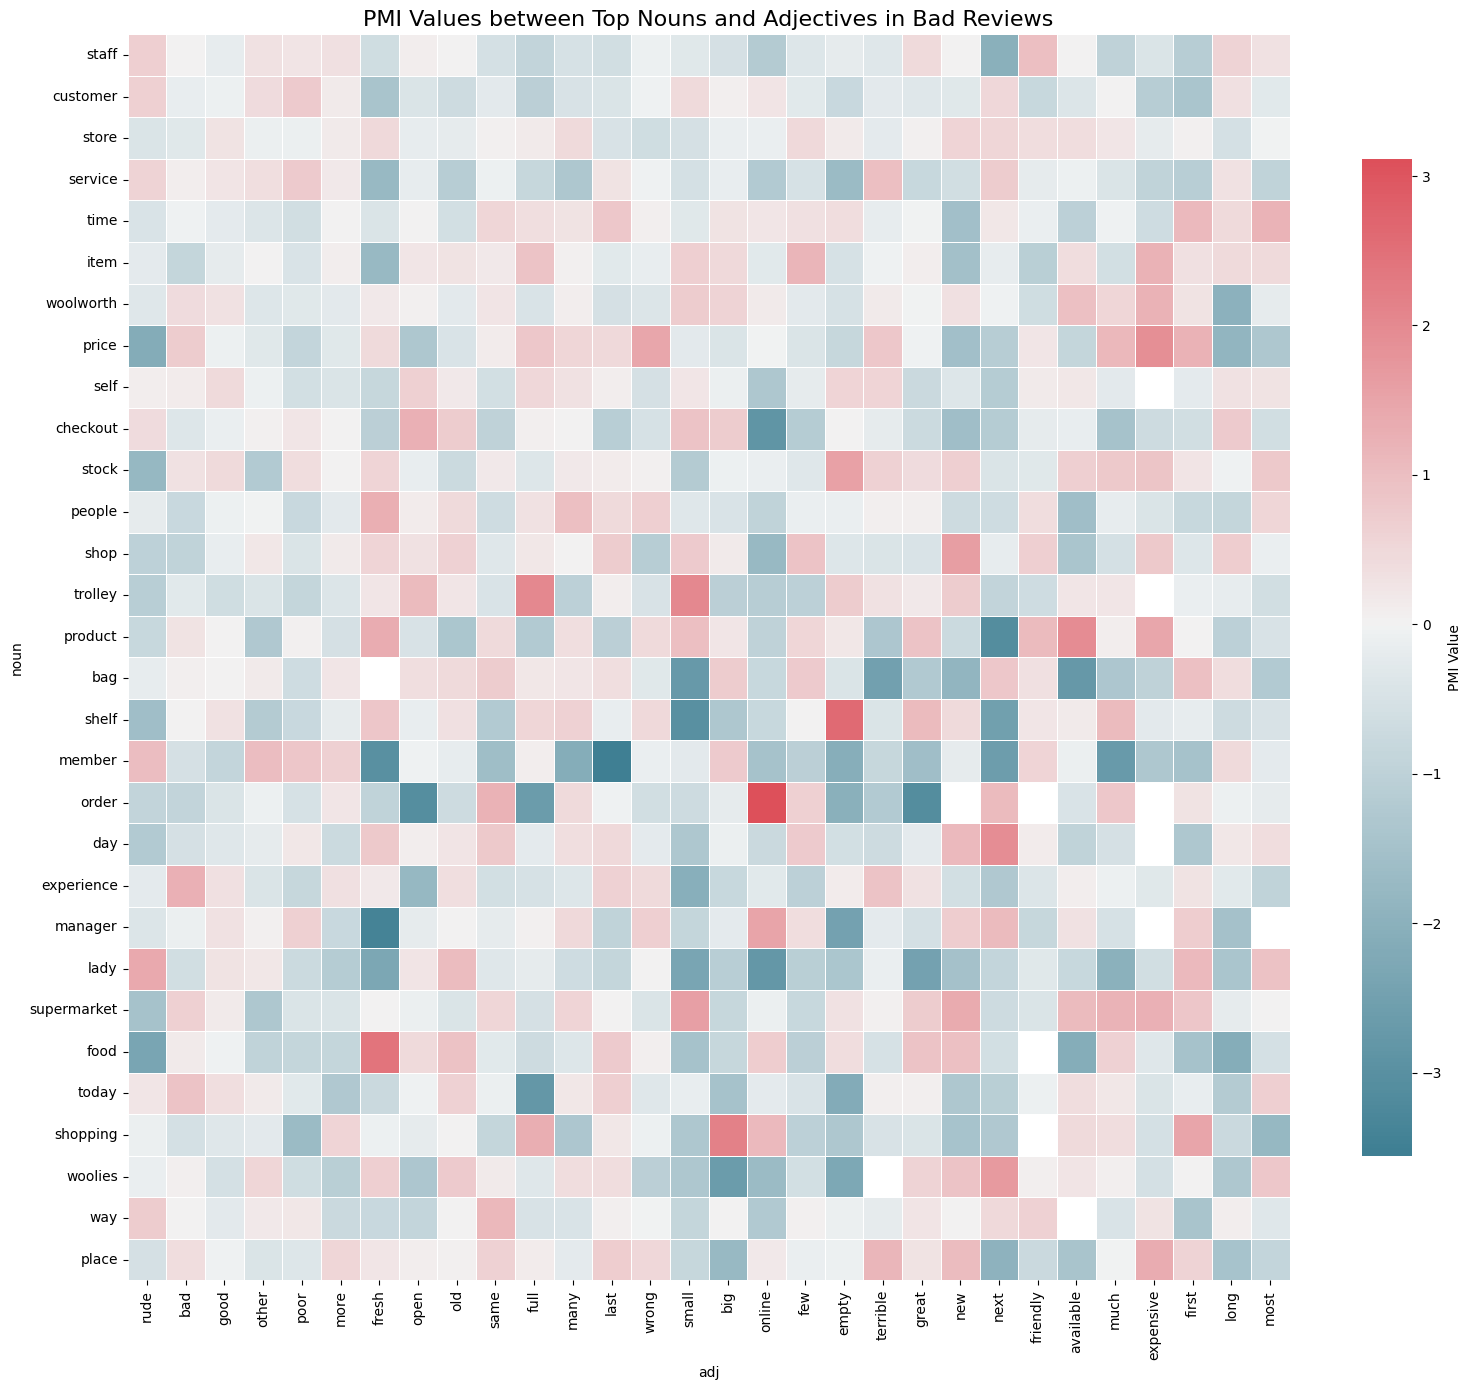

In [ ]:
plt.figure(figsize=(16, 14))
mask = pmi_df.isnull() | (pmi_df == 0)  # Optional: mask undefined or zero values

# Use a diverging colormap since PMI can be positive or negative
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(pmi_df,
                      mask=mask,
                      cmap=cmap,
                      center=0,
                      annot=False,  # Too many values to annotate clearly
                      fmt=".2f",
                      linewidths=.5,
                      cbar_kws={"shrink": .8, "label": "PMI Value"})

plt.title('PMI Values between Top Nouns and Adjectives in Bad Reviews', fontsize=16)
plt.tight_layout()
plt.savefig('pmi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

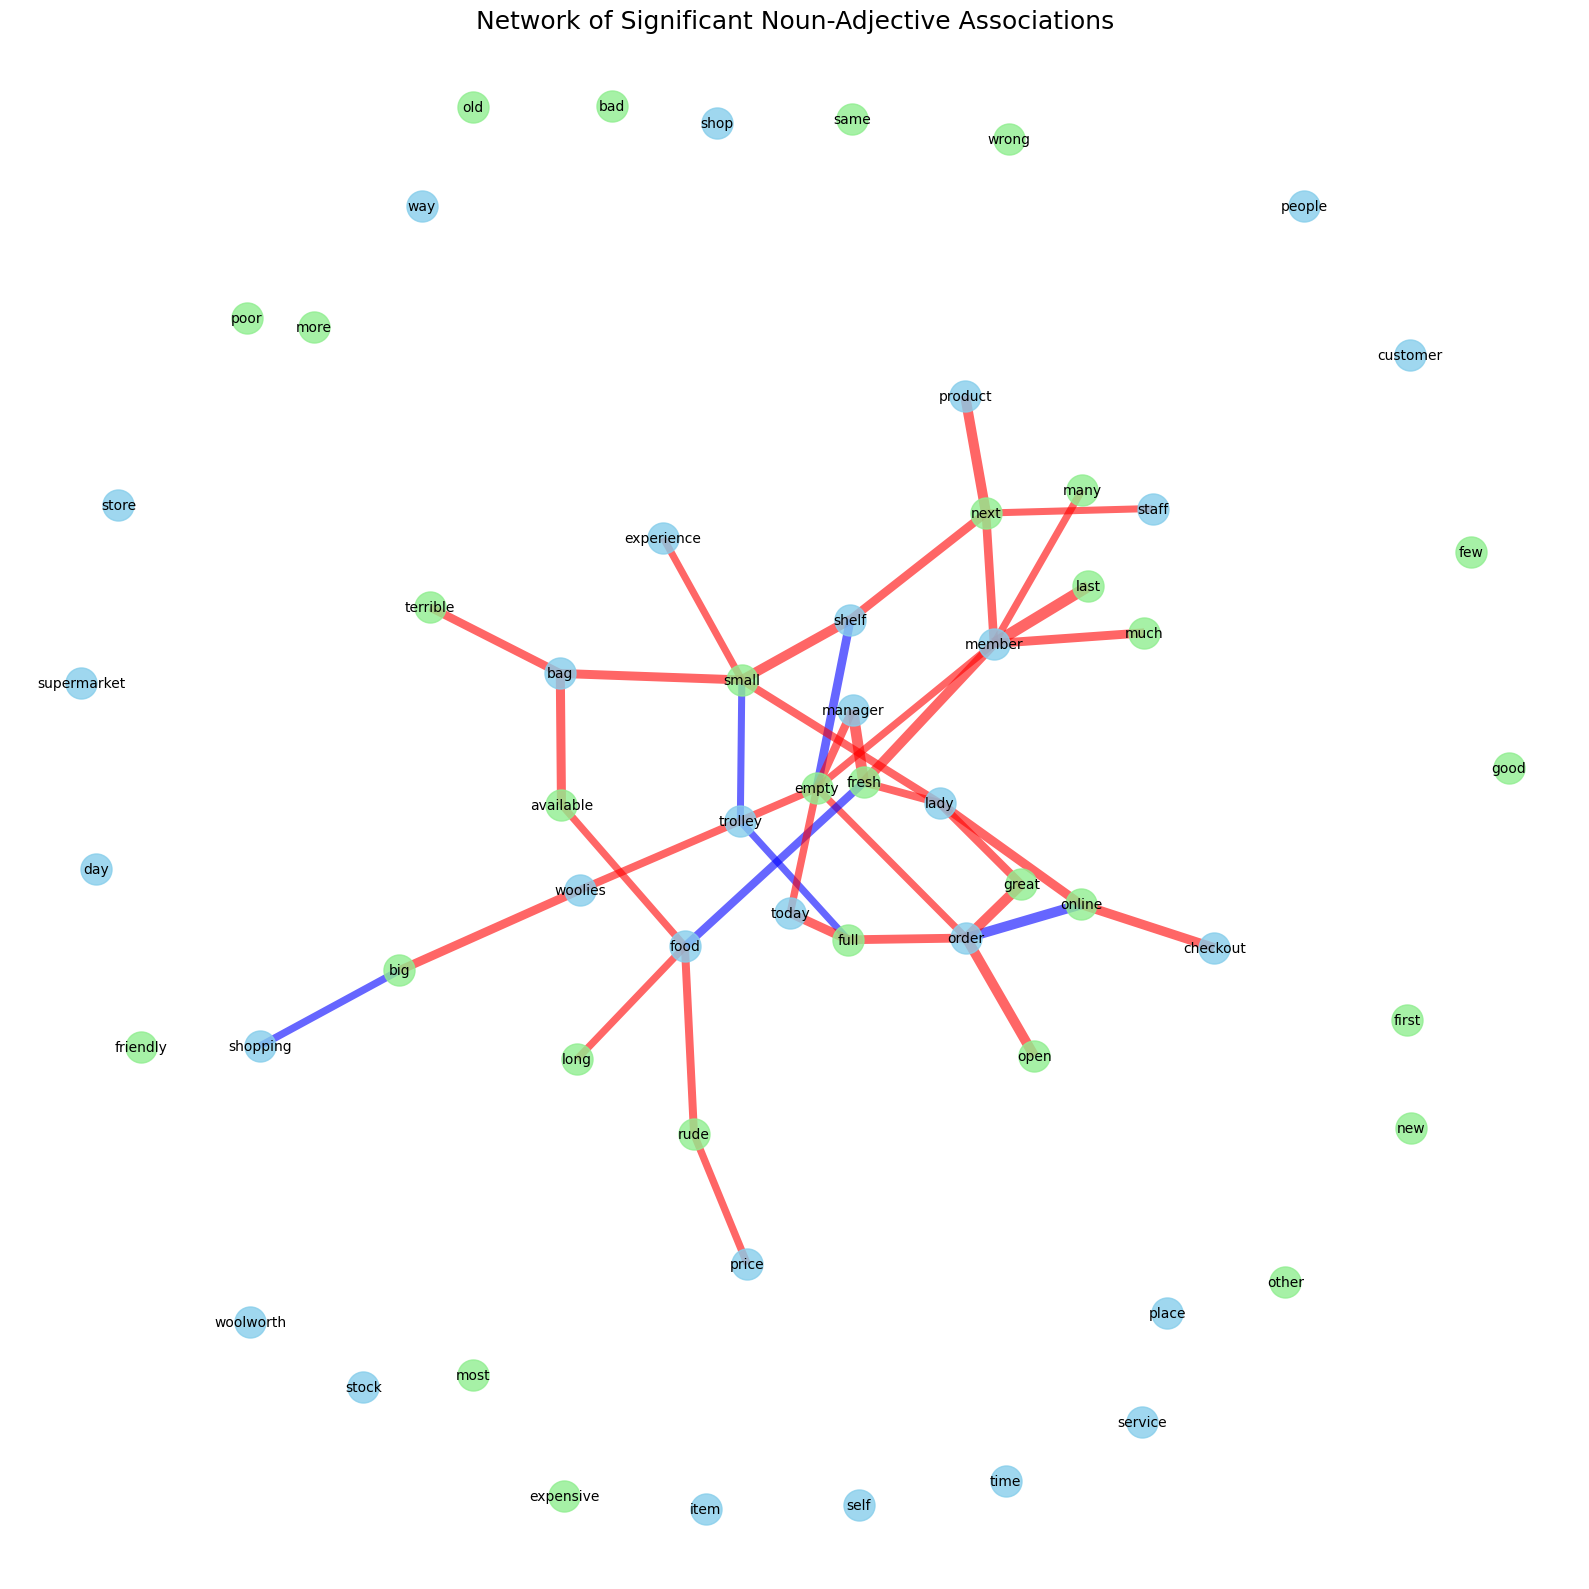

In [ ]:
import networkx as nx
from matplotlib.colors import Normalize

G = nx.Graph()

# Add nodes
for noun in pmi_df.index:
    G.add_node(noun, type='noun')
for adj in pmi_df.columns:
    G.add_node(adj, type='adjective')

# Add edges with significant PMI values
threshold = 2.0  # Higher threshold to keep the graph readable
norm = Normalize(vmin=-5, vmax=5)  # Normalize PMI values for edge widths

for noun in pmi_df.index:
    for adj in pmi_df.columns:
        pmi_value = pmi_df.loc[noun, adj]
        if abs(pmi_value) > threshold:
            # Edge width based on absolute PMI value, color based on sign
            G.add_edge(noun, adj, weight=abs(pmi_value), pmi=pmi_value)

# Plot network
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, k=0.4, iterations=50)  # Position nodes using force-directed layout

# Draw nodes with different colors for nouns and adjectives
noun_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'noun']
adj_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'adjective']

nx.draw_networkx_nodes(G, pos, nodelist=noun_nodes, node_color='skyblue', node_size=500, alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=adj_nodes, node_color='lightgreen', node_size=500, alpha=0.8)

# Draw edges with color based on PMI sign and width based on absolute value
edges = G.edges(data=True)
edge_colors = ['red' if edge[2]['pmi'] < 0 else 'blue' for edge in edges]
edge_weights = [1 + 2 * edge[2]['weight'] for edge in edges]  # Scale for visibility

nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.title('Network of Significant Noun-Adjective Associations', fontsize=18)
plt.tight_layout()
plt.savefig('pmi_network.png', dpi=300, bbox_inches='tight')
plt.show()

Check the association between (staff, customer, store, services) versus (rude, bad, good, other)

Question: Why did they complaint about (staff, customer, service) are (rude, bad)

In [ ]:
# Define the target noun-adjective pairs
inspects = [('staff', 'rude'), ('staff', 'bad'), ('customer', 'rude'),
            ('customer', 'bad'), ('service', 'rude'), ('service', 'bad')]

# Filter reviews where both noun and adj columns contain any target pairs
filtered_reviews = (bad_reviews[
    bad_reviews.apply(lambda row: any((noun in row['noun'] and adj in row['adj']) for noun, adj in inspects), axis=1)]
                    ['ProcessedReview']).tolist()

# Association Rules mining

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import numpy as np

def prepare_data_for_apriori(df, min_support=0.01):
    """
    Prepare review data for apriori analysis by creating binary encoded matrix.
    Each row represents a review, each column represents a word (noun or adjective).
    """
    # Filter to reviews from 2023 onwards
    filtered_df = df[df['Year'] >= 2023].copy()

    # Create a list of all words (nouns and adjectives) to consider
    all_nouns = set()
    all_adjectives = set()

    for nouns in filtered_df['noun']:
        all_nouns.update(nouns)

    for adjectives in filtered_df['adj']:
        all_adjectives.update(adjectives)

    # Create a dictionary to store binary values for each review
    review_dict = {}

    # For each review, mark 1 if the word appears, 0 otherwise
    for idx, row in filtered_df.iterrows():
        for noun in all_nouns:
            col_name = f"noun_{noun}"
            if col_name not in review_dict:
                review_dict[col_name] = []
            review_dict[col_name].append(1 if noun in row['noun'] else 0)

        for adj in all_adjectives:
            col_name = f"adj_{adj}"
            if col_name not in review_dict:
                review_dict[col_name] = []
            review_dict[col_name].append(1 if adj in row['adj'] else 0)

    # Convert the dictionary to a DataFrame
    encoded_df = pd.DataFrame(review_dict)

    return encoded_df

def find_frequent_itemsets(encoded_df, min_support=0.01):
    """
    Apply Apriori algorithm to find frequent itemsets.
    """
    frequent_itemsets = apriori(encoded_df,
                                min_support=min_support,
                                use_colnames=True,
                                max_len=5)  # Limiting to sets of max 5 items for practicality

    return frequent_itemsets

# Step 3: Generate association rules from frequent itemsets
def generate_association_rules(frequent_itemsets, min_threshold=0.7):
    """
    Generate association rules from frequent itemsets.
    """
    rules = association_rules(frequent_itemsets,
                             metric="confidence",
                             min_threshold=min_threshold)

    # Sort rules by lift (a measure of interestingness)
    rules = rules.sort_values('lift', ascending=False)

    return rules

def get_interesting_rules(rules, top_n=20):
    """
    Extract and format the most interesting rules for interpretation.
    """
    # Create a more readable format for the rules
    formatted_rules = []

    for idx, row in rules.head(top_n).iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])

        # Format the rule
        antecedents_str = " & ".join([word.replace('noun_', '') if word.startswith('noun_') else
                                     word.replace('adj_', '') for word in antecedents])
        consequents_str = " & ".join([word.replace('noun_', '') if word.startswith('noun_') else
                                     word.replace('adj_', '') for word in consequents])

        rule_str = f"{antecedents_str} → {consequents_str}"

        formatted_rules.append({
            "rule": rule_str,
            "support": row['support'],
            "confidence": row['confidence'],
            "lift": row['lift']
        })

    return pd.DataFrame(formatted_rules)

def analyze_noun_adj_associations(rules):
    """
    Filter rules to find those that associate nouns with adjectives.
    """
    noun_adj_rules = []

    for idx, row in rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])

        # Check if antecedents contain nouns and consequents contain adjectives
        has_noun_to_adj = any(item.startswith('noun_') for item in antecedents) and \
                          any(item.startswith('adj_') for item in consequents)

        # Check if antecedents contain adjectives and consequents contain nouns
        has_adj_to_noun = any(item.startswith('adj_') for item in antecedents) and \
                          any(item.startswith('noun_') for item in consequents)

        if has_noun_to_adj or has_adj_to_noun:
            antecedents_str = " & ".join([word.replace('noun_', 'noun:') if word.startswith('noun_') else
                                        word.replace('adj_', 'adj:') for word in antecedents])
            consequents_str = " & ".join([word.replace('noun_', 'noun:') if word.startswith('noun_') else
                                        word.replace('adj_', 'adj:') for word in consequents])

            rule_str = f"{antecedents_str} → {consequents_str}"

            noun_adj_rules.append({
                "rule": rule_str,
                "support": row['support'],
                "confidence": row['confidence'],
                "lift": row['lift']
            })

    return pd.DataFrame(noun_adj_rules)

# Prepare data for Apriori
encoded_df = prepare_data_for_apriori(bad_reviews)

# Find frequent itemsets
frequent_itemsets = find_frequent_itemsets(encoded_df, min_support=0.02)

# Generate association rules
rules = generate_association_rules(frequent_itemsets, min_threshold=0.5)

# Get the most interesting rules overall
top_rules = get_interesting_rules(rules, top_n=30)

# Get noun-adjective specific associations
noun_adj_rules = analyze_noun_adj_associations(rules)
noun_adj_rules = noun_adj_rules.sort_values('lift', ascending=False).head(30)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
top_rules

In [ ]:
reviews.to_csv('processed.csv',index=False)

# Topic modeling

In [ ]:
#Extract reviews on rules keywords
keywords = ['staff']
topic_reviews = reviews[reviews['Nouns'].apply(lambda x: all(keyword in x for keyword in keywords))]

KeyError: 'Nouns'

In [ ]:
#Remove stopwords
def remove_stopwords(text):
  tokens = word_tokenize(text)
  filtered_tokens = [word for word in tokens if word not in stop_words]
  return ' '.join(filtered_tokens)
topic_reviews['ReadyReview'] = topic_reviews['ProcessedReview'].apply(remove_stopwords)

In [ ]:
#Vectorize
text_reviews = [''.join(doc) for doc in topic_reviews[(topic_reviews['Rating']<3)&(topic_reviews['Year']>2023)]['ReadyReview']]
#Using Bag of Word (Word frequency)
vectorizer = TfidfVectorizer()
bag_of_words = vectorizer.fit_transform(text_reviews)

In [ ]:
#Modeling
from sklearn.decomposition import LatentDirichletAllocation, NMF
nmf = NMF(
    n_components=15,
    solver='mu',
    init="nndsvd",       # Better initialization for sparse data
    max_iter=1000,       # Ensure convergence
    random_state=42
)
nmf.fit(bag_of_words)
feature_names = vectorizer.get_feature_names_out()

In [ ]:
def nmf_error(topic):
  nmf = NMF(
      n_components=topic,
      solver='mu',
      init='random',
      max_iter=1000,
      random_state=2025)
  nmf.fit(bag_of_words)
  est_error = nmf.reconstruction_err_
  return est_error

In [ ]:
performance = dict()
for topic in range(5,30):
  performance[topic] = nmf_error(topic)
sns.lineplot(performance)

In [ ]:
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10:-1]]))
print(nmf.reconstruction_err_)